In [1]:
import sklearn
from sklearn.cluster import KMeans
from sklearn.datasets import fetch_covtype
import numpy as np
import scipy as scp
from scipy import sparse

NUM_SAMPLES = 150
LARGE_VAL = 10000000
ITER_THRESH = 5

In [2]:
#A function to get the 20 newsgroup data
def get_data():
    #news_groups_all = fetch_20newsgroups(subset='all')
    #news_data = news_groups_all.data

    #Load in the vectorized news group data from scikit-learn package
    cov = fetch_covtype()
    all_data = np.array(cov.data)
    all_targets = np.array(cov.target)
    
    #Set class pairings as described in the multiview clustering paper
    view1_classes = [1, 2, 3]
    view2_classes = [4, 5, 6]
    
    #Create lists to hold data and labels for each of the 5 classes across 2 different views
    labels =  [num for num in range(len(view1_classes)) for _ in range(NUM_SAMPLES)]
    labels = np.array(labels)
    view1_data = list()
    view2_data = list()
    
    #Randomly sample 200 items from each of the selected classes in view1
    for class_num in view1_classes:
        class_data = all_data[(all_targets == class_num)]
        indices = np.random.choice(class_data.shape[0], NUM_SAMPLES)
        view1_data.append(class_data[indices])
    view1_data = np.concatenate(view1_data)
   
        
    #Randomly sample 200 items from each of the selected classes in view2
    for class_num in view2_classes:
        class_data = all_data[(all_targets == class_num)]
        indices = np.random.choice(class_data.shape[0], NUM_SAMPLES)
        view2_data.append(class_data[indices])  
    view2_data = np.concatenate(view2_data)

    #Shuffle and normalize vectors
    shuffled_inds = np.random.permutation(NUM_SAMPLES * len(view1_classes))
    view1_data = np.vstack(view1_data)
    view2_data = np.vstack(view2_data)
    view1_data = view1_data[shuffled_inds]
    view2_data = view2_data[shuffled_inds]
    magnitudes1 = np.linalg.norm(view1_data, axis=0)
    magnitudes2 = np.linalg.norm(view2_data, axis=0)
    magnitudes1[magnitudes1 == 0] = 1
    magnitudes2[magnitudes2 == 0] = 1
    magnitudes1 = magnitudes1.reshape((1, -1))
    magnitudes2 = magnitudes2.reshape((1, -1))
    view1_data /= magnitudes1
    view2_data /= magnitudes2
    labels = labels[shuffled_inds]
    return view1_data, view2_data, labels


In [3]:
from sklearn.datasets import load_digits
from sklearn.datasets import fetch_olivetti_faces
import cv2
import numpy as np
NUM_SAMPLES = 100
LARGE_VAL = 10000000
ITER_THRESH = 5

In [4]:
def get_data2():
    dataset = load_digits()
    data = dataset['data']
    images = dataset['images']
    all_targets = dataset['target']
    gradients = cv2.Sobel(images, cv2.CV_64F,1,0,ksize=3)
    gradients = (gradients - np.min(gradients))/ (1.0 * (np.max(gradients) - np.min(gradients)))
    images = (images - np.min(images))/(1.0 * (np.max(images) - np.min(images)))
    im_hist = list()
    grad_hist = list()
    for ind in range(images.shape[0]):
        im, _ = np.histogram(images[ind], bins = 16)
        grad, _ = np.histogram(gradients[ind], bins = 64)
        im_hist.append(im)
        grad_hist.append(grad)
    im_hist = np.array(im_hist)
    grad_hist = np.array(grad_hist)


    view1_classes = [0, 1, 3]
    #new_targets = np.zeros(all_targets.shape)
    #for ind in range(5):
    #    new_targets[all_targets % 5 == ind] = ind
    #all_targets = new_targets
    
    #Create lists to hold data and labels for each of the 5 classes across 2 different views
    labels =  [num for num in range(len(view1_classes)) for _ in range(NUM_SAMPLES)]
    labels = np.array(labels)
    view1_data = list()
    view2_data = list()
    
    #Randomly sample 150 items from each of the selected classes in view1
    for class_num in view1_classes:
        class_data = im_hist[(all_targets == class_num)]
        indices = np.random.choice(class_data.shape[0], NUM_SAMPLES)
        view1_data.append(class_data[indices])
    view1_data = np.concatenate(view1_data)
   
        
    #Randomly sample 150 items from each of the selected classes in view2
    for class_num in view1_classes:
        class_data = grad_hist[(all_targets == class_num)]
        indices = np.random.choice(class_data.shape[0], NUM_SAMPLES)
        view2_data.append(class_data[indices])  
    view2_data = np.concatenate(view2_data)
    
    #Shuffle and normalize vectors
    shuffled_inds = np.random.permutation(NUM_SAMPLES * len(view1_classes))
    view1_data = view1_data[shuffled_inds]
    view2_data = view2_data[shuffled_inds]
    labels = labels[shuffled_inds]
    return view1_data, view2_data, labels


In [5]:
v1_data, v2_data, labels = get_data()

In [6]:
#Function to initialize partitions
def compute_distances(data, c_centers, k): 
    distances = list()
    for cl in range(k):
        dist = data - c_centers[cl]
        dist = np.linalg.norm(dist, axis = 1)
        distances.append(dist)
    distances = np.vstack(distances)
    return distances

#A function to compute the value of the objective function
def compute_objective(data, c_centers, partitions):

    o_funct = 0
    for clust in range(c_centers.shape[0]):
        vecs = data[(partitions == clust)]
        dist = np.linalg.norm(vecs - c_centers[clust], axis=1)
        o_funct += np.sum(dist)
        
    return o_funct


#A function to run through a single iteration of maximization and expectation
#(in that order)
def iterate_clusters(data, partitions, k):

    #Recompute cluster centers
    new_centers = list()
    for clust in range(k):
        vec = np.mean(data[(partitions == clust)], axis = 0)
        new_centers.append(vec)
    new_centers = np.vstack(new_centers)
        
    #Assign each sample point to a partition
    distances = compute_distances(data, new_centers, k)
    new_partitions = np.argmin(distances, axis = 0).flatten()

    return new_centers, new_partitions


In [7]:
#A function to consolidate the final clusters from the two views
def final_clusters(v_data, v_partitions, c_centers, k):

    v1_consensus = list()
    v2_consensus = list()
    for clust in range(k):
        part_indices = (v_partitions[0] == clust) * (v_partitions[1] == clust)
        #View 1
        vec1 = np.mean(v_data[0][part_indices], axis = 0)
        v1_consensus.append(vec1)

        #View 2
        vec2 = np.mean(v_data[1][part_indices], axis = 0)
        v2_consensus.append(vec2)
        
    v1_consensus = np.vstack(v1_consensus)
    v2_consensus = np.vstack(v2_consensus)
        
    dist1 = compute_distances(v_data[0], v1_consensus, k)
    dist2 = compute_distances(v_data[1], v2_consensus, k)
    dist_metric = dist1 + dist2
    new_partitions = np.argmin(dist_metric,axis = 0).flatten()
    return new_partitions

In [8]:
def compute_entropy(partitions, labels, k, num_classes):
    
    total_entropy = 0
    num_examples = partitions.shape[0]
    for part in range(k):
        labs = labels[partitions == part]
        part_size = labs.shape[0]
        if(part_size == 0):
            part_size = 1
        part_entropy = 0
        for cl in range(num_classes):
            prop = np.sum(labs == cl) * 1.0 / part_size
            ent = 0
            if(prop != 0):
                ent = - prop * np.log2(prop)
            part_entropy += ent
        part_entropy = part_entropy * part_size / num_examples
        total_entropy += part_entropy
    return total_entropy

In [9]:
#The main kmeans clustering algorithm
def kmeans(v_data, labels, k = 3):

    #Initialize cluster centers, partitions, and loop params
    indices = np.random.choice(v_data[1].shape[0], k)
    c_centers2 = v_data[1][indices]
    c_centers = [None, c_centers2]
    
    distances2 = compute_distances(v_data[1], c_centers2, k)
    partitions2 = np.argmin(distances2,axis = 0).flatten()
    
    v_partitions = [None, partitions2]
    objective = [LARGE_VAL, LARGE_VAL]
    iter_stall = 0
    iter_num = 0
    entropy = 0

    while(iter_stall < ITER_THRESH):
        iter_num += 1
        view = (iter_num + 1) % 2
        
        #Switch partitions, Maximization, and Expectation
        c_centers[view], v_partitions[view] = iterate_clusters(v_data[view], v_partitions[(view + 1) % 2], k)
        o_funct = compute_objective(v_data[view], c_centers[view], v_partitions[view])
        iter_stall += 1
        
        #Recompute objective function
        if(o_funct < objective[view]):
            objective[view] = o_funct
            iter_stall = 0
        
        
        #Obtain evaluation metrics
        f_clusters = final_clusters(v_data, v_partitions, c_centers, k)
        entropy = compute_entropy(f_clusters, labels, k, 3)

    return entropy
            

In [10]:
def single_kmeans(v_data, labels, k = 3):

    #Initialize cluster centers, partitions, and loop params
    indices = np.random.choice(v_data.shape[0], k)
    c_centers = v_data[indices]
    
    distances = compute_distances(v_data, c_centers, k)
    v_partitions = np.argmin(distances,axis = 0).flatten()
    
    objective = LARGE_VAL
    iter_stall = 0
    iter_num = 0
    entropy = 0

    while(iter_stall < ITER_THRESH):
        iter_num += 1
        view = (iter_num + 1) % 2
        
        #Switch partitions, Maximization, and Expectation
        c_centers, v_partitions = iterate_clusters(v_data, v_partitions, k)
        o_funct = compute_objective(v_data, c_centers, v_partitions)
        iter_stall += 1
        
        #Recompute objective function
        if(o_funct < objective):
            objective = o_funct
            iter_stall = 0
        
        
        #Obtain evaluation metric
        entropy = compute_entropy(v_partitions, labels, k, 3)

    return entropy

In [11]:
#ent = kmeans([v1_data, v2_data], labels, 3)
import math

In [12]:
def getEntropies(v1_data, v2_data, labels):
    entropies = list()
    for num in range(1, 7):
        ent = kmeans([v1_data, v2_data], labels, num)
        entropies.append(ent)
    return entropies

def getSingleEntropies(v1_data, v2_data, labels):
    
    v_data = np.concatenate([v1_data, v2_data], axis = 1)
    entropies = list()
    
    for k in range(1, 7):
        ent = single_kmeans(v_data, labels, k)
        entropies.append(ent)
        
    return entropies

#Do multiview kmeans and get entropy values for each k
num_trials = 100
mult_entropies = list()
for ind in range(num_trials):
    entropies = getEntropies(v1_data, v2_data, labels)
    mult_entropies.append(entropies)
mult_entropies = np.array(mult_entropies)
print(mult_entropies)
mult_entropies = np.mean(mult_entropies, axis=0)


#Do single view kmeans
num_trials = 100
sing_entropies = list()
for ind in range(num_trials):
    entropies = getSingleEntropies(v1_data, v2_data, labels)
    sing_entropies.append(entropies)
sing_entropies = np.array(sing_entropies)
sing_entropies = np.mean(sing_entropies, axis=0)

C:\Users\Alexander\Anaconda3\envs\py36\lib\site-packages\numpy\core\fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Alexander\Anaconda3\envs\py36\lib\site-packages\numpy\core\_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


[[1.5849625  1.00301794 0.8905974  0.62712643 0.77842364 0.60793565]
 [1.5849625  1.00301794 0.86818469 0.58584081 0.60327232 0.9077061 ]
 [1.5849625  1.00301794 0.61580139 0.54729587 0.60156474 0.76759841]
 [1.5849625  1.09706167 0.85648673 0.67897624 0.64518726 0.55310861]
 [1.5849625  0.98852355 0.93656164 0.85493446 0.56085609 0.57048262]
 [1.5849625  0.99523623 0.83970972 0.80915313 0.83805365 0.56733573]
 [1.5849625  0.98852355 1.02759102 0.93242053 0.81396636 0.74108615]
 [1.5849625  1.00301794 0.60714126 0.66716366 0.51130275 0.85188855]
 [1.5849625  1.00301794 1.04923252 0.65452818 0.77908213 0.81905911]
 [1.5849625  0.99523623 0.63472296 0.87871334 0.69695937 0.85741595]
 [1.5849625  0.99523623 0.93656164 1.5849625  0.81215126 0.63346395]
 [1.5849625  1.00301794 0.98238191 0.71042068 0.8306606  0.71849483]
 [1.5849625  0.99523623 1.00640339 0.65418409 0.60927175 0.82951879]
 [1.5849625  1.00301794 0.77584853 0.88589244 0.88328145 0.61487782]
 [1.5849625  1.09706167 0.93442356

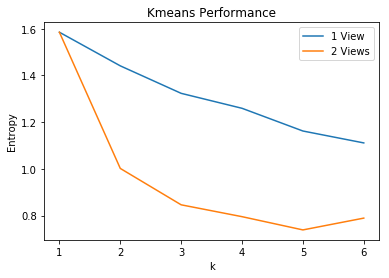

In [14]:
import matplotlib.pyplot as plt
x_values = list(range(1, 7))
plt.plot(x_values, sing_entropies, x_values, mult_entropies)
plt.xlabel('k')
plt.ylabel('Entropy')
plt.legend(['1 View', '2 Views'])
plt.title('Kmeans Performance')
plt.show()